In [1]:
import scanpy as sc
import squidpy as sq

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


/cm/shared/easybuild/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Standard Process

### Load data

In [ ]:
xenium_path = "nbl_xenium"
zarr_path = "nbl_xenium/Xenium.zarr"

sdata = xenium(xenium_path)
sdata.write(zarr_path, overwrite = True)

sdata = sd.read_zarr(zarr_path)
adata = sdata.table['table']

## add mouse_id information to cells
mids = pd.read_csv('cell_mouse_id.csv', index_col = 0)
mids.index = mids.index.astype('str')
adata.obs = adata.obs.join(mids[['mouse_id']])


In [ ]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [ ]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

### Process

In [ ]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=50)

In [ ]:
adata.layers["counts"] = adata.X.copy()


In [ ]:
sc.pp.normalize_total(adata, inplace=True)

sc.pp.log1p(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
        'mouse_id'
    ],
    wspace=0.4,
)

In [ ]:
adata


In [ ]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
        "mouse_id"
    ],
    wspace=0.4,
)

## Run harmony integration

In [ ]:
sc.external.pp.harmony_integrate(adata, 'mouse_id')

sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata)



In [ ]:
sc.tl.louvain(adata, resolution = 0.8)


In [ ]:
sc.pl.umap(adata, color=["mouse_id", "louvain"])

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

In [ ]:
sc.pl.violin(adata, ['total_counts'], 
             groupby="louvain", size = 0)

In [ ]:
adata

In [ ]:
for i in range(0,9):
    cluster_data = adata.obs.loc[adata.obs['louvain'] == str(i)]['total_counts']
    # Calculate the median of 'total_counts' for the current cluster
    median_value = cluster_data.median()
    mean_value = cluster_data.mean()
    # Print the median value
    print(f"Cluster {i}: Median total_counts = {median_value}, Mean total_counts = {mean_value}")


In [ ]:
adata.write_h5ad('nbl_xenium_anndata.h5ad', compression='gzip')


## Remove low quality cluster 2 and redo


#### Redo

In [ ]:
adata = adata[adata.obs['louvain'] != '2']


In [ ]:
sc.pp.pca(adata)
sc.external.pp.harmony_integrate(adata, 'mouse_id')

sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

sc.tl.louvain(adata, resolution = 0.8)
sc.pl.umap(adata, color=["mouse_id", "louvain"])


In [ ]:
sc.pl.violin(adata, ['total_counts'], 
             groupby="louvain", size = 0)
for i in range(0,9):
    cluster_data = adata.obs.loc[adata.obs['louvain'] == str(i)]['total_counts']
    # Calculate the median of 'total_counts' for the current cluster
    median_value = cluster_data.median()
    mean_value = cluster_data.mean()
    # Print the median value
    print(f"Cluster {i}: Median total_counts = {median_value}, Mean total_counts = {mean_value}")


In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', key_added = "wilcoxon")


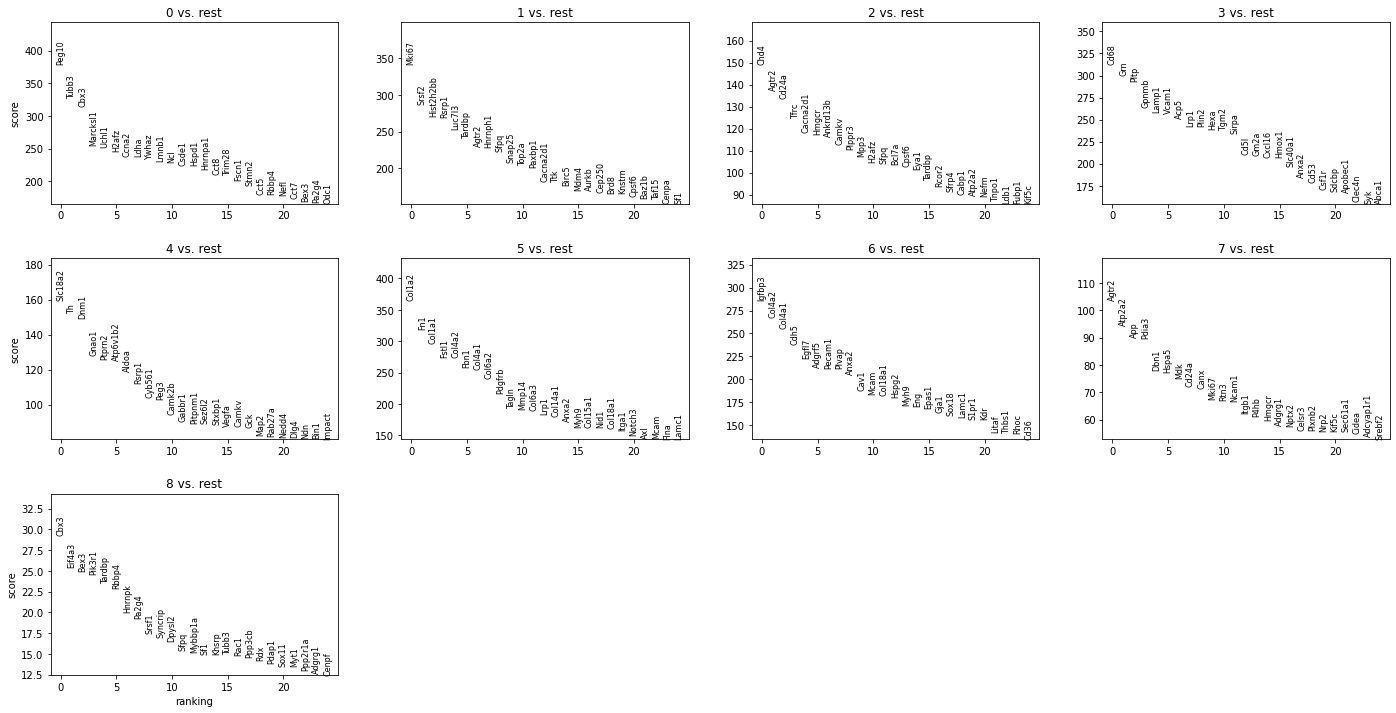

In [95]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

In [ ]:
sc.pl.umap(adata, color=['louvain'], legend_loc='on data')

In [97]:
de_results= adata.uns['wilcoxon']

# Get the top-ranked genes for each cluster
top_genes = de_results['names']

# Get the log fold changes for these genes
log_fold_changes = de_results['logfoldchanges']


# Convert the results to a pandas DataFrame
groups = de_results['names'].dtype.names
result_dfs = []  # List to store DataFrames for each group

for group in groups:
  # Create a DataFrame for each group
  result_df = pd.DataFrame({
      'gene': de_results['names'][group],
      'score': de_results['scores'][group],
      'logfoldchange': de_results['logfoldchanges'][group],
      'pval': de_results['pvals'][group],
      'pval_adj': de_results['pvals_adj'][group],
      'cluster': group
  })
  result_dfs.append(result_df)

# Concatenate all the DataFrames into a single DataFrame
final_result_df = pd.concat(result_dfs, ignore_index=True)
final_result_df.to_csv('de_results_louvain.csv', index=False)
final_result_df



,gene,score,logfoldchange,pval,pval_adj,cluster
0,Peg10,379.189941,0.906128,0.000000e+00,0.000000e+00,0
1,Tubb3,326.494263,1.016273,0.000000e+00,0.000000e+00,0
2,Cbx3,315.472778,0.816786,0.000000e+00,0.000000e+00,0
3,Marcksl1,254.480484,0.824951,0.000000e+00,0.000000e+00,0
4,Uchl1,252.731339,0.747384,0.000000e+00,0.000000e+00,0
...,...,...,...,...,...,...
45049,Dek,-20.053301,-1.938781,1.888886e-89,8.596147e-87,8
45050,Lmnb1,-23.296240,-2.232149,4.839917e-120,2.692069e-117,8
45051,Cct8,-26.232641,-2.302204,1.127917e-151,1.411588e-148,8
45052,Ncl,-27.154039,-3.147473,2.268647e-162,3.785615e-159,8


In [ ]:
adata.obs["cell_type"] = adata.obs["louvain"].map(
    {
        "0": "Neuroblast",
        "1": "Neuroblast",
        "2": "Neuroblast",
        "3": "Macrophage",
        "4": "Neuroblast",
        "5": "Fibroblast",
        "6": "Endothelial",
        "7": "Neuroblast",
        "8": "Neuroblast",
    }
)

In [ ]:
adata.obs["treatment"] = adata.obs["mouse_id"].map(
    {
        "1630": "Control",
        "1608": "Control",
        "1666": "Control",
        "1080": "Treated",
        "1400": "Treated",
        "1634": "Treated",
    }
)
adata.obs['treatment'].value_counts()





In [ ]:
adata.uns.pop('treatment_colors', None)
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "treatment"
    ],
    shape=None,
    size=2,
    img=False,
)

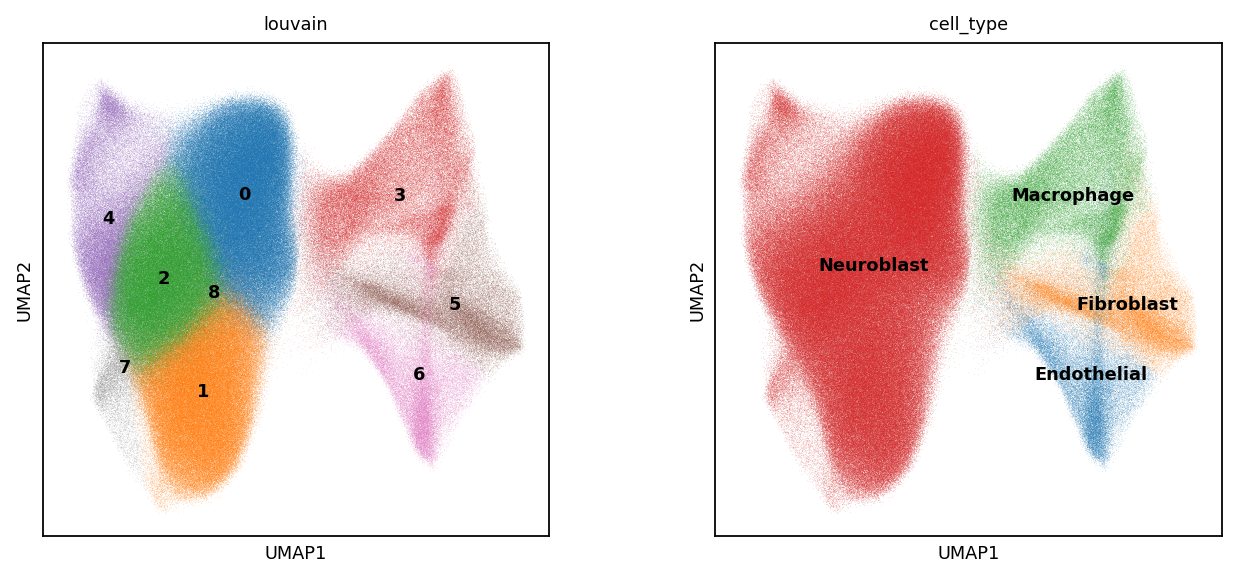

In [58]:
fdir = 'Figures/RNA/Xenium/'
sc.settings.figdir = fdir
sc.set_figure_params(dpi_save = '300', fontsize = 8)
sc.pl.umap(adata, color=['louvain', 'cell_type'], legend_loc='on data',
           show = False)
plt.savefig(fdir + 'umap_xenium_python.pdf', format = 'pdf')

plt.show()


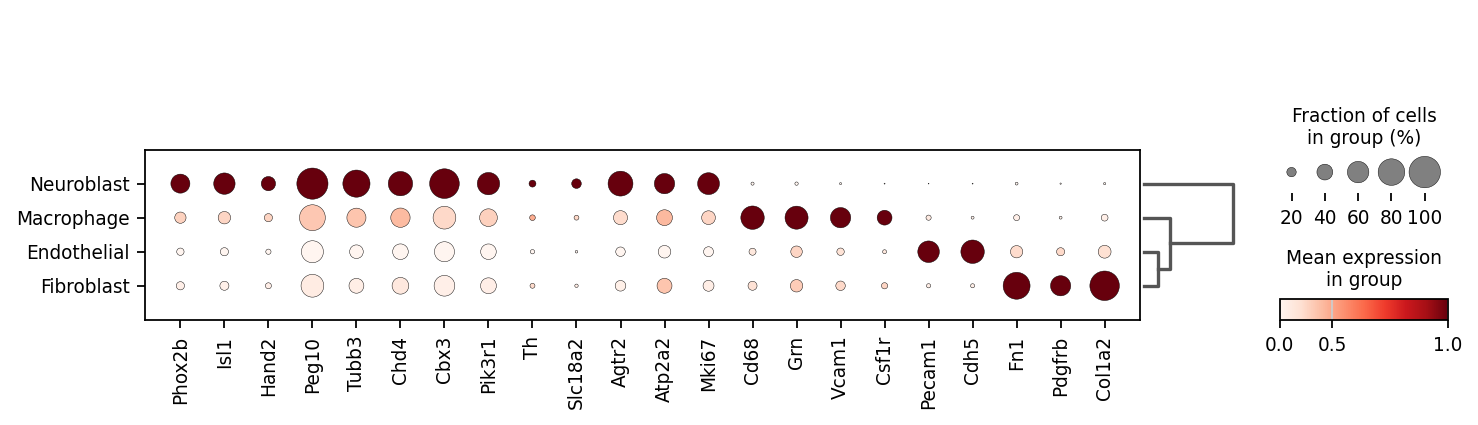

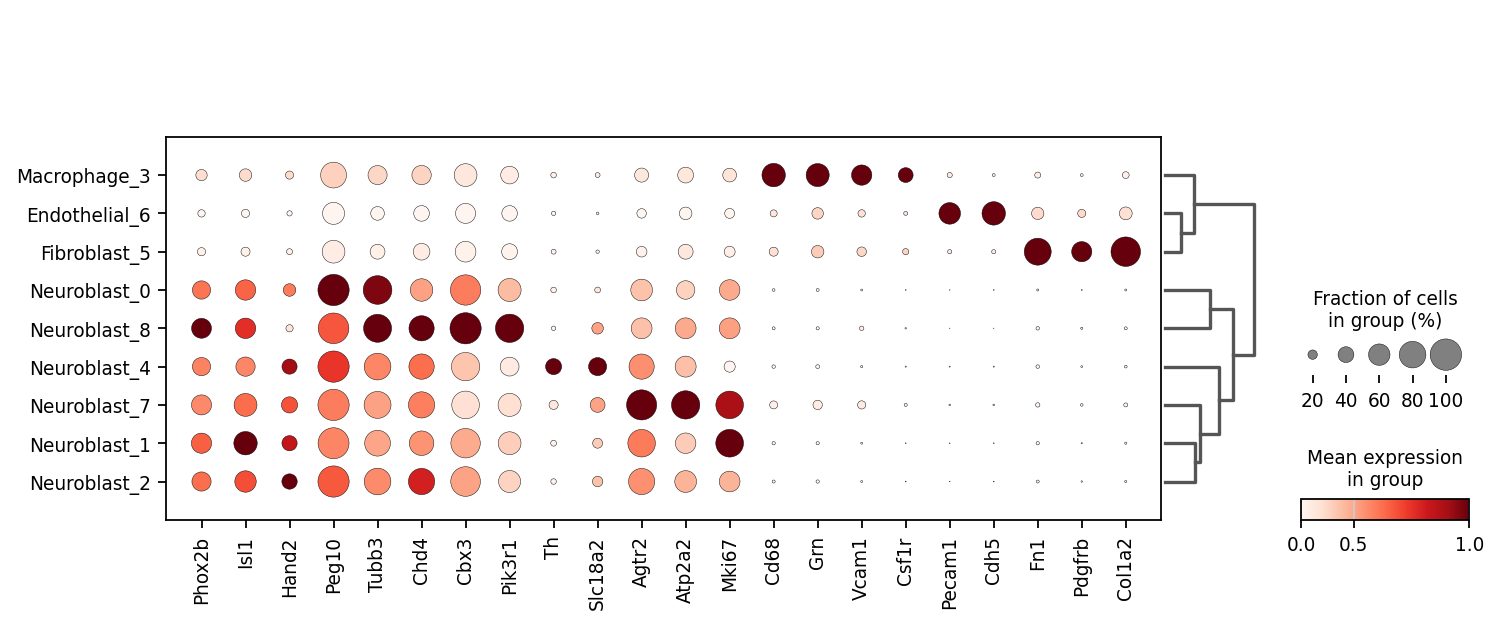

In [41]:
plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as text, not as paths
plt.rcParams['svg.fonttype'] = 'none'  # Ensures text is stored as text in SVG

sc.set_figure_params(fontsize = 10, dpi_save = '300')
markers =  ['Phox2b', 'Isl1', 'Hand2',
           'Peg10','Tubb3', 'Chd4', 'Cbx3','Pik3r1',  'Th', 'Slc18a2', 
           'Agtr2', 'Atp2a2', 'Mki67',  
           'Cd68', 'Grn', 'Vcam1', 'Csf1r',  
           'Pecam1', 'Cdh5', 'Fn1', 'Pdgfrb', "Col1a2"]
sc.pl.dotplot(adata, markers, groupby=['cell_type'], dendrogram=True, 
              show = False, standard_scale = 'var', vcenter = 0.8)
plt.savefig(fdir + 'dotplot_markers_celltype.pdf', format = 'pdf')

sc.pl.dotplot(adata, markers, groupby=['cell_type', 'louvain'], dendrogram=True, 
             show = False, standard_scale = 'var', vcenter = 0.8)
plt.savefig(fdir + 'dotplot_markers_cluster.pdf', format = 'pdf')
#
#sc.pl.dotplot(adata, markers, groupby=['cell_type'], dendrogram=True, 
#              save = 'dotplot_markers_celltype.pdf')

plt.show()

In [ ]:
adata.write_h5ad('nbl_xenium_anndata_final.h5ad', compression='gzip')


In [4]:
adata

AnnData object with n_obs × n_vars = 993070 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'kmeans', 'mouse_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'louvain', 'cell_type', 'treatment', 'subtype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'louvain', 'louvain_colors', 'mouse_id_colors', 'neighbors', 'patient_id_colors', 'pca', 'spatialdata_attrs', 'treatment_colo

In [52]:
print(adata.uns.keys())

dict_keys(['cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'louvain', 'louvain_colors', 'mouse_id_colors', 'neighbors', 'patient_id_colors', 'pca', 'spatialdata_attrs', 'treatment_colors', 'umap', 'wilcoxon'])


### Cell subtype annotation

In [212]:
def get_expr(gene_of_interest):
    gene_expression = adata[:, gene_of_interest].layers['counts']
    if hasattr(gene_expression, "toarray"):
        gene_expression = gene_expression.toarray().flatten()
    else:
        gene_expression = gene_expression.flatten()
    return gene_expression

# Create a pandas Series for easy statistical analysis
gene_expression = get_expr('Erbb4')
gene_expression_series = pd.Series(gene_expression)
# Compute summary statistics
summary_stats = gene_expression_series.describe()

print(summary_stats)




count    993070.000000
mean          0.002399
std           0.049815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
dtype: float64


In [206]:
# Apply the annotation function to each row in adata.obs
adata.obs['subtype'] = adata.obs['cell_type']


gene_expression = get_expr('Erbb4')
# Convert 'subtype' to categorical if it's not already
if not pd.api.types.is_categorical_dtype(adata.obs['subtype']):
    adata.obs['subtype'] = adata.obs['subtype'].astype('category')
    
# Add the new category if it doesn't exist
if 'Erbb4+Neuroblast' not in adata.obs['subtype'].cat.categories:
    adata.obs['subtype'] = adata.obs['subtype'].cat.add_categories(['Erbb4+Neuroblast'])  
adata.obs.loc[(adata.obs['cell_type'] == 'Neuroblast') & (gene_expression >= 1), 'subtype'] = 'Erbb4+Neuroblast'

gene_expression = get_expr('Hbegf')
# Add the new category if it doesn't exist
if 'Hbegf+Macrophage' not in adata.obs['subtype'].cat.categories:
    adata.obs['subtype'] = adata.obs['subtype'].cat.add_categories(['Hbegf+Macrophage'])
adata.obs.loc[(adata.obs['cell_type'] == 'Macrophage') & (gene_expression >= 1), 'subtype'] = 'Hbegf+Macrophage'


gene_expression = get_expr('Vcan')
# Add the new category if it doesn't exist
if 'Vcan+Macrophage' not in adata.obs['subtype'].cat.categories:
    adata.obs['subtype'] = adata.obs['subtype'].cat.add_categories(['Vcan+Macrophage'])
adata.obs.loc[(adata.obs['cell_type'] == 'Macrophage') & (gene_expression >= 1), 'subtype'] = 'Vcan+Macrophage'




/tmp/ipykernel_1721251/2710178776.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs['subtype']):


In [208]:
adata.write_h5ad('nbl_xenium_anndata_final.h5ad', compression='gzip')